In [1]:
import pandas as pd
from pycaret.classification import *

#from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import xgboost as xgb
import shap
import numpy as np
from xgboost import plot_importance

Load data

In [2]:
data_consolidada = pd.read_csv('data_consolidados_sentinel2_distancias_indices_era5.csv')
data_consolidada.head()

,Unnamed: 0.1,Unnamed: 0,time,dim_0,coastal,blue,green,red,nir08,swir16,...,total_precipitation_sum,u_component_of_wind_10m,u_component_of_wind_10m_max,u_component_of_wind_10m_min,v_component_of_wind_10m,v_component_of_wind_10m_max,v_component_of_wind_10m_min,volumetric_soil_water_layer_1,volumetric_soil_water_layer_1_max,volumetric_soil_water_layer_1_min
0,0,0,2022-02-02,0,0.1324,0.1278,0.1418,0.1498,0.2619,0.2929,...,2.682209e-07,1.796789,4.297897,-0.679688,-0.072233,0.688393,-0.924824,0.249864,0.249893,0.249817
1,1,1,2022-02-02,1,0.1313,0.1252,0.1425,0.1383,0.2820,0.2676,...,2.682209e-07,1.796789,4.297897,-0.679688,-0.072233,0.688393,-0.924824,0.249864,0.249893,0.249817
2,2,2,2022-02-02,2,0.1388,0.1322,0.1465,0.1517,0.2457,0.2914,...,2.682209e-07,1.796789,4.297897,-0.679688,-0.072233,0.688393,-0.924824,0.249864,0.249893,0.249817
3,3,3,2022-02-02,3,0.1325,0.1284,0.1394,0.1420,0.2357,0.2532,...,2.682209e-07,1.796789,4.297897,-0.679688,-0.072233,0.688393,-0.924824,0.249864,0.249893,0.249817
4,4,4,2022-02-02,4,0.1350,0.1376,0.1542,0.1680,0.2580,0.3237,...,2.682209e-07,1.796789,4.297897,-0.679688,-0.072233,0.688393,-0.924824,0.249864,0.249893,0.249817


In [3]:
data_consolidada.shape

(202264, 61)

#### Procesamiento input modelo

In [4]:
# eliminamos columnas que no nos son de interes para el modelo
aux = data_consolidada.drop(['nom_incen','causa', 'provincia', 'comuna', 'codreg', 'codprov', 'codcom', 'superficie', 'spatial_ref', 'temporada', 'region', 'fecha_ter', 'Unnamed: 0', 'Unnamed: 0.1', 'dim_0', 'geometry'], axis= 1)
aux

,time,coastal,blue,green,red,nir08,swir16,swir22,y,x,...,total_precipitation_sum,u_component_of_wind_10m,u_component_of_wind_10m_max,u_component_of_wind_10m_min,v_component_of_wind_10m,v_component_of_wind_10m_max,v_component_of_wind_10m_min,volumetric_soil_water_layer_1,volumetric_soil_water_layer_1_max,volumetric_soil_water_layer_1_min
0,2022-02-02,0.1324,0.1278,0.1418,0.1498,0.2619,0.2929,0.2298,6265890.0,269650.0,...,2.682209e-07,1.796789,4.297897,-0.679688,-0.072233,0.688393,-0.924824,0.249864,0.249893,0.249817
1,2022-02-02,0.1313,0.1252,0.1425,0.1383,0.2820,0.2676,0.2038,6264130.0,269930.0,...,2.682209e-07,1.796789,4.297897,-0.679688,-0.072233,0.688393,-0.924824,0.249864,0.249893,0.249817
2,2022-02-02,0.1388,0.1322,0.1465,0.1517,0.2457,0.2914,0.2357,6263950.0,268650.0,...,2.682209e-07,1.796789,4.297897,-0.679688,-0.072233,0.688393,-0.924824,0.249864,0.249893,0.249817
3,2022-02-02,0.1325,0.1284,0.1394,0.1420,0.2357,0.2532,0.2015,6264110.0,271090.0,...,2.682209e-07,1.796789,4.297897,-0.679688,-0.072233,0.688393,-0.924824,0.249864,0.249893,0.249817
4,2022-02-02,0.1350,0.1376,0.1542,0.1680,0.2580,0.3237,0.2530,6263770.0,267790.0,...,2.682209e-07,1.796789,4.297897,-0.679688,-0.072233,0.688393,-0.924824,0.249864,0.249893,0.249817
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202259,2020-12-19,0.0547,0.0712,0.1033,0.1552,0.2478,0.3660,0.2628,6413410.0,337370.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202260,2020-12-19,0.0785,0.0973,0.1426,0.2115,0.2704,0.2834,0.2419,6414050.0,355550.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202261,2020-12-19,0.0538,0.0695,0.0983,0.1443,0.2249,0.3125,0.2389,6418430.0,299270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
202262,2020-12-19,0.0468,0.0439,0.0708,0.0812,0.2504,0.2722,0.1827,6438610.0,291270.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Filtramos pixeles que posean al menos un historial de 3 imagenes recolectadas:

In [5]:
n_id= aux['id_pixel_incendio'].value_counts()
aux = aux.merge(n_id, how = 'left', on = 'id_pixel_incendio')
aux = aux[ aux['count']>=3].drop('count', axis =1)
aux.shape

(179985, 45)

Filtramos fechas de captura según el inicio del incendio. Nos quedaremos solo con la información del estado previo al incendio, es decir, si el tiempo de captura es menor o igual al inicio del incendio.

In [6]:
# transformamos a fecha
aux['fecha_ini'] = pd.to_datetime(aux['fecha_ini'])
aux['time'] = pd.to_datetime(aux['time'])

# Filtrar las fechas actuales que son anteriores a la fecha de inicio
filtro = aux['time'] <= aux['fecha_ini']
fechas_antiguas = aux[filtro]

# Quedarse con la fecha actual más cercana a la fecha de inicio
fechas_antiguas['Diferencia'] = (fechas_antiguas['time'] - fechas_antiguas['fecha_ini']).abs()

Puesto que hay imagenes que poseen problemas en la captura y producen valores faltantes en el dataset, se realizó una imputación según el valor anterior capturado tal como se muestra a continuación:

In [7]:
fechas_antiguas_interp = fechas_antiguas.sort_values(by= ['id_pixel_incendio', 'time']).groupby('id_pixel_incendio').apply(lambda group: group.interpolate(method= 'pad')).reset_index(drop= True)

In [8]:
# Ejemplo
print(fechas_antiguas[fechas_antiguas['id_pixel']==17])

fechas_antiguas_interp[fechas_antiguas_interp['id_pixel']==17]

           time  coastal    blue   green     red   nir08  swir16  swir22  \
16   2022-02-02   0.1388  0.1468  0.1661  0.1921  0.2996  0.3563  0.2639   
2228 2022-02-07   0.3886  0.4340  0.4210  0.4248  0.4677  0.5206  0.4503   
4440 2022-02-12   0.1413  0.1469  0.1654  0.1883  0.2893  0.3462  0.2643   
6652 2022-02-17   0.1388  0.1504  0.1615  0.1873  0.2859  0.3394  0.2642   
8864 2022-02-22      NaN     NaN     NaN     NaN     NaN     NaN     NaN   

              y         x  ...  u_component_of_wind_10m  \
16    6265870.0  270830.0  ...                 1.796789   
2228  6265870.0  270830.0  ...                 1.525106   
4440  6265870.0  270830.0  ...                 1.252339   
6652  6265870.0  270830.0  ...                 1.613927   
8864  6265870.0  270830.0  ...                 1.014877   

     u_component_of_wind_10m_max u_component_of_wind_10m_min  \
16                      4.297897                   -0.679688   
2228                    3.959015                    0.018539

,time,coastal,blue,green,red,nir08,swir16,swir22,y,x,...,u_component_of_wind_10m,u_component_of_wind_10m_max,u_component_of_wind_10m_min,v_component_of_wind_10m,v_component_of_wind_10m_max,v_component_of_wind_10m_min,volumetric_soil_water_layer_1,volumetric_soil_water_layer_1_max,volumetric_soil_water_layer_1_min,Diferencia
70542,2022-02-02,0.1388,0.1468,0.1661,0.1921,0.2996,0.3563,0.2639,6265870.0,270830.0,...,1.796789,4.297897,-0.679688,-0.072233,0.688393,-0.924824,0.249864,0.249893,0.249817,21 days
70543,2022-02-07,0.3886,0.4340,0.4210,0.4248,0.4677,0.5206,0.4503,6265870.0,270830.0,...,1.525106,3.959015,0.018539,-0.785921,0.216309,-1.597580,0.250044,0.250183,0.249847,16 days
70544,2022-02-12,0.1413,0.1469,0.1654,0.1883,0.2893,0.3462,0.2643,6265870.0,270830.0,...,1.252339,3.305115,-0.384216,-1.294714,0.122762,-3.036286,0.250001,0.250031,0.249939,11 days
70545,2022-02-17,0.1388,0.1504,0.1615,0.1873,0.2859,0.3394,0.2642,6265870.0,270830.0,...,1.613927,4.945160,-0.743942,0.581790,0.936739,0.104034,0.249907,0.249954,0.249832,6 days
70546,2022-02-22,0.1388,0.1504,0.1615,0.1873,0.2859,0.3394,0.2642,6265870.0,270830.0,...,1.014877,3.723633,-0.954651,-1.251980,-0.272659,-2.516647,0.249769,0.249786,0.249741,1 days


Una vez interpolado los valores faltantes, pasamos a la siguiente etapa: dejar la información a nivel de pixel, en donde identificamos los valores más cercanos antes del incendio y realizamos un promedio a nivel de pixel-incendio para los demas datos, obteniendo columnas con la situación actual y otras con el historial previo:

In [9]:
idx = fechas_antiguas_interp.groupby(['id_pixel_incendio'])['Diferencia'].idxmin()
fecha_cercana = fechas_antiguas_interp.loc[idx].drop(['coastal', 'blue', 'green', 'red', 'nir08', 'swir16',	'swir22', 'time2'], axis = 1)

Calculamos el promedio:

In [10]:
fechas_antiguas_resum = fechas_antiguas_interp.drop(['time', 'y', 'x', 'es_incendio', 'fecha_ini', 'Diferencia', 'tipo_dato', 'id_pixel','id_incendio', 'time2',
                                                     'coastal', 'blue', 'green', 'red', 'nir08', 'swir16',	'swir22',                                                # eliminamos la infomación de las bandas
                                                     'd_areas_silvestres_protegidas', 'd_red_hidrografica', 'd_areas_urbanas','d_red_vial'], axis =1)                 # eliminamos de distancias pues es el mismo pixel
ind_fechas_antiguas = fechas_antiguas_interp[['y', 'x', 'es_incendio', 'id_incendio', 'id_pixel']].drop_duplicates()

promedio = fechas_antiguas_resum.groupby(['id_pixel_incendio']).mean()
promedio

,ndvi,evi,ndwi,dewpoint_temperature_2m,dewpoint_temperature_2m_max,dewpoint_temperature_2m_min,soil_temperature_level_1,soil_temperature_level_1_max,soil_temperature_level_1_min,temperature_2m,...,total_precipitation_sum,u_component_of_wind_10m,u_component_of_wind_10m_max,u_component_of_wind_10m_min,v_component_of_wind_10m,v_component_of_wind_10m_max,v_component_of_wind_10m_min,volumetric_soil_water_layer_1,volumetric_soil_water_layer_1_max,volumetric_soil_water_layer_1_min
id_pixel_incendio,,,,,,,,,,,,,,,,,,,,,
2016-2017-104-13275,0.747302,0.313434,0.172112,282.174499,284.911077,279.201955,296.354335,308.723872,286.299047,292.576469,...,0.000120,0.638061,2.318019,-1.062608,0.103451,0.839816,-0.682479,0.146767,0.149968,0.138229
2016-2017-104-2083,0.836314,0.253355,0.246712,284.268818,285.841258,283.254517,296.183952,304.751867,289.700648,291.252006,...,0.000001,1.519517,4.073023,-0.401321,3.248165,4.650551,2.299033,0.176087,0.176173,0.175908
2016-2017-104-2283,0.163585,0.099741,-0.087652,284.268818,285.841258,283.254517,296.183952,304.751867,289.700648,291.252006,...,0.000001,1.519517,4.073023,-0.401321,3.248165,4.650551,2.299033,0.176087,0.176173,0.175908
2016-2017-104-2314,0.695956,0.306123,0.213982,284.268818,285.841258,283.254517,296.183952,304.751867,289.700648,291.252006,...,0.000001,1.519517,4.073023,-0.401321,3.248165,4.650551,2.299033,0.176087,0.176173,0.175908
2016-2017-104-2784,0.706291,0.255024,0.160011,284.268818,285.841258,283.254517,296.183952,304.751867,289.700648,291.252006,...,0.000001,1.519517,4.073023,-0.401321,3.248165,4.650551,2.299033,0.176087,0.176173,0.175908
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-2023-4-49542,0.034575,0.018420,0.099872,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-2023-4-49543,0.232758,0.139127,-0.073352,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2022-2023-4-49544,0.226516,0.179758,-0.068663,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
df_cols = fecha_cercana.merge(promedio, how = 'left', on = ['id_pixel_incendio'], suffixes=['_t', '_tmean'])
df_cols = df_cols.drop(['Diferencia'], axis =1)
df_proc = df_cols

Revisamos valores faltantes nuevamente:

In [12]:
df_proc.isna().sum()

time                                         0
y                                            0
x                                            0
es_incendio                                  0
id_incendio                                  0
                                          ... 
v_component_of_wind_10m_max_tmean          742
v_component_of_wind_10m_min_tmean          742
volumetric_soil_water_layer_1_tmean        742
volumetric_soil_water_layer_1_max_tmean    742
volumetric_soil_water_layer_1_min_tmean    742
Length: 61, dtype: int64

Al realizar la imputación de valores faltantes dependemos de los demás valores existentes, en el caso de que no exista información, eliminaremos el pixel.

In [13]:
# Ejemplo:
fechas_antiguas_interp[fechas_antiguas_interp['id_pixel']== 24720]  # a

,time,coastal,blue,green,red,nir08,swir16,swir22,y,x,...,u_component_of_wind_10m,u_component_of_wind_10m_max,u_component_of_wind_10m_min,v_component_of_wind_10m,v_component_of_wind_10m_max,v_component_of_wind_10m_min,volumetric_soil_water_layer_1,volumetric_soil_water_layer_1_max,volumetric_soil_water_layer_1_min,Diferencia
85390,2021-07-02,NaN,NaN,NaN,NaN,NaN,0.0927,0.0998,6370590.0,381430.0,...,-1.449002,-0.548264,-2.263870,0.011151,0.249710,-0.106354,0.207290,0.207306,0.207275,23 days
85391,2021-07-07,0.9445,NaN,NaN,NaN,NaN,0.0812,0.0918,6370590.0,381430.0,...,-1.648202,-0.712418,-2.509979,0.021126,0.113708,-0.136797,0.207205,0.207214,0.207199,18 days
85392,2021-07-17,0.9162,NaN,NaN,NaN,0.9641,0.0555,0.0614,6370590.0,381430.0,...,-1.992614,-1.335205,-2.422699,0.018242,0.075043,-0.137924,0.207745,0.207779,0.207703,8 days
85393,2021-07-22,0.9968,NaN,NaN,NaN,0.9943,0.0474,0.0503,6370590.0,381430.0,...,-1.646520,-0.587463,-2.217499,-0.061281,0.022629,-0.102203,0.223948,0.237076,0.220612,3 days


In [14]:
df_proc = df_proc.dropna()  # eliminando

In [15]:
df_proc['es_incendio'].value_counts()

es_incendio
0    28405
1     6457
Name: count, dtype: int64

Data consolidada procesada:

In [16]:
df_proc.head()

,time,y,x,es_incendio,id_incendio,fecha_ini,tipo_dato,id_pixel,id_pixel_incendio,d_areas_silvestres_protegidas,...,total_precipitation_sum_tmean,u_component_of_wind_10m_tmean,u_component_of_wind_10m_max_tmean,u_component_of_wind_10m_min_tmean,v_component_of_wind_10m_tmean,v_component_of_wind_10m_max_tmean,v_component_of_wind_10m_min_tmean,volumetric_soil_water_layer_1_tmean,volumetric_soil_water_layer_1_max_tmean,volumetric_soil_water_layer_1_min_tmean
0,2017-03-10,6263970.0,278670.0,0,2016-2017-104,2017-03-12,zona_random,13275,2016-2017-104-13275,25388.446707,...,0.000120,0.638061,2.318019,-1.062608,0.103451,0.839816,-0.682479,0.146767,0.149968,0.138229
1,2017-03-10,6336590.0,262030.0,0,2016-2017-104,2017-03-12,zona_incendio,2083,2016-2017-104-2083,4234.191694,...,0.000001,1.519517,4.073023,-0.401321,3.248165,4.650551,2.299033,0.176087,0.176173,0.175908
2,2017-03-10,6337090.0,262390.0,1,2016-2017-104,2017-03-12,zona_incendio,2283,2016-2017-104-2283,4499.957523,...,0.000001,1.519517,4.073023,-0.401321,3.248165,4.650551,2.299033,0.176087,0.176173,0.175908
3,2017-03-10,6336370.0,262090.0,0,2016-2017-104,2017-03-12,zona_incendio,2314,2016-2017-104-2314,4013.175417,...,0.000001,1.519517,4.073023,-0.401321,3.248165,4.650551,2.299033,0.176087,0.176173,0.175908
4,2017-03-10,6336490.0,262330.0,0,2016-2017-104,2017-03-12,zona_incendio,2784,2016-2017-104-2784,3999.401165,...,0.000001,1.519517,4.073023,-0.401321,3.248165,4.650551,2.299033,0.176087,0.176173,0.175908


Para reducir el desbalanceo seleccionaremos de forma aleatoria pixeles de clase no incendio

In [17]:
import random
random.seed(2024)
index = random.sample(df_proc[df_proc['es_incendio']==0].index.to_list(), 12914)

In [18]:
index

[19136,
 7741,
 30359,
 23684,
 12603,
 8348,
 30204,
 17112,
 31372,
 29978,
 31447,
 10947,
 21838,
 10290,
 26079,
 33589,
 30588,
 20399,
 14705,
 17302,
 21646,
 30343,
 25361,
 8938,
 12792,
 22188,
 29305,
 13496,
 21385,
 3209,
 30461,
 32231,
 8550,
 28176,
 31156,
 30340,
 19085,
 29564,
 34447,
 26615,
 6156,
 21786,
 8756,
 17172,
 2471,
 32064,
 14549,
 25834,
 17325,
 18999,
 5174,
 30263,
 30859,
 5848,
 31663,
 13369,
 16160,
 13529,
 14387,
 32863,
 8379,
 13316,
 17660,
 17253,
 13019,
 23323,
 8804,
 17010,
 9626,
 8488,
 1443,
 31069,
 9392,
 31614,
 637,
 10739,
 34871,
 20823,
 13110,
 32156,
 23405,
 33214,
 29366,
 17471,
 25254,
 4439,
 13550,
 35119,
 26622,
 24873,
 32428,
 9719,
 9992,
 18946,
 15083,
 5754,
 8442,
 15184,
 20120,
 24272,
 34614,
 25815,
 5928,
 10840,
 15937,
 25669,
 13921,
 13824,
 29542,
 29785,
 18968,
 35455,
 7024,
 28007,
 28385,
 31912,
 35454,
 5619,
 13601,
 8568,
 23775,
 28089,
 2780,
 3978,
 34858,
 7261,
 142,
 6231,
 18087,
 

In [19]:
df_proc_new = pd.concat([df_proc.loc[index], df_proc[df_proc['es_incendio']==1]], axis =0)

In [20]:
df_proc_new['es_incendio'].value_counts()

es_incendio
0    12914
1     6457
Name: count, dtype: int64

In [21]:
#df_proc[['d_areas_silvestres_protegidas', 'd_red_hidrografica', 'd_areas_urbanas','d_red_vial']] = df_proc[['d_areas_silvestres_protegidas', 'd_red_hidrografica', 'd_areas_urbanas','d_red_vial']].round(4)

#### Separación y obtencion de scaler

Realizamos separación train-test según incendios, para ello dejaremos como testeo el ultimo año con incendios:

In [22]:
df_proc_new['id_incendio'].value_counts()

id_incendio
2018-2019-62     1296
2020-2021-11     1285
2018-2019-63     1279
2020-2021-1      1272
2018-2019-64     1271
2018-2019-0      1246
2022-2023-2      1231
2021-2022-5      1225
2020-2021-0      1224
2021-2022-4      1216
2022-2023-0      1211
2022-2023-3      1192
2016-2017-104    1185
2021-2022-3      1129
2022-2023-4      1116
2022-2023-1       964
2016-2017-136      20
2016-2017-87        9
Name: count, dtype: int64

In [23]:
df_proc_new['agno_inicio_incendio'] = [item.split("-", 1)[0] for item in df_proc_new['id_incendio']]

In [24]:
agno_incendios = list(set([item.split("-", 1)[0] for item in df_proc_new['id_incendio'].unique()]))
agno_incendios.sort()
ultimo_agno = agno_incendios[-1]  # testeo 2022

filtro_agno = df_proc_new['agno_inicio_incendio'].apply(lambda x: ultimo_agno in x)

In [25]:
X_test = df_proc_new[filtro_agno]
X_train = df_proc_new[-filtro_agno]
X_train

,time,y,x,es_incendio,id_incendio,fecha_ini,tipo_dato,id_pixel,id_pixel_incendio,d_areas_silvestres_protegidas,...,u_component_of_wind_10m_tmean,u_component_of_wind_10m_max_tmean,u_component_of_wind_10m_min_tmean,v_component_of_wind_10m_tmean,v_component_of_wind_10m_max_tmean,v_component_of_wind_10m_min_tmean,volumetric_soil_water_layer_1_tmean,volumetric_soil_water_layer_1_max_tmean,volumetric_soil_water_layer_1_min_tmean,agno_inicio_incendio
19136,2022-02-22,6344570.0,394890.0,0,2021-2022-3,2022-02-23,zona_random,24494,2021-2022-3-24494,82869.594612,...,1.477213,3.541275,-0.011783,0.327348,1.548809,-0.688016,0.251515,0.251563,0.251434,2021
7741,2019-01-24,6348930.0,284270.0,0,2018-2019-63,2019-01-26,zona_random,40896,2018-2019-63-40896,15517.009100,...,0.684187,2.511160,-0.858508,-0.252011,0.070113,-0.698189,0.178315,0.192772,0.157669,2018
23684,2022-02-27,6350150.0,364350.0,0,2021-2022-5,2022-02-28,zona_random,26549,2021-2022-5-26549,52015.514424,...,1.023560,3.349281,-0.684174,-0.463304,0.195862,-1.143547,0.050770,0.058243,0.043297,2021
12603,2021-01-13,6438330.0,359850.0,0,2020-2021-0,2021-01-15,zona_random,49994,2020-2021-0-49994,98063.880346,...,1.205887,2.550864,-0.148400,0.407744,0.924523,0.037759,0.148351,0.148495,0.148197,2020
8348,2019-01-24,6351990.0,273490.0,0,2018-2019-63,2019-01-26,zona_random,41503,2018-2019-63-41503,18676.148471,...,1.248803,2.761453,0.088299,0.301786,0.796311,-0.170572,0.251289,0.251358,0.251183,2018
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
24525,2022-02-27,6335950.0,261590.0,1,2021-2022-5,2022-02-28,zona_incendio,2892,2021-2022-5-2892,3893.922330,...,1.667908,4.514786,-0.063469,2.892419,4.671333,2.033778,0.119444,0.119484,0.119370,2021
24528,2022-02-27,6334250.0,261990.0,1,2021-2022-5,2022-02-28,zona_incendio,2895,2021-2022-5-2895,2254.794164,...,1.667908,4.514786,-0.063469,2.892419,4.671333,2.033778,0.119444,0.119484,0.119370,2021
24529,2022-02-27,6336130.0,260630.0,1,2021-2022-5,2022-02-28,zona_incendio,2896,2021-2022-5-2896,4572.249919,...,1.667908,4.514786,-0.063469,2.892419,4.671333,2.033778,0.119444,0.119484,0.119370,2021
24532,2022-02-27,6335370.0,262010.0,1,2021-2022-5,2022-02-28,zona_incendio,2899,2021-2022-5-2899,3182.287612,...,1.667908,4.514786,-0.063469,2.892419,4.671333,2.033778,0.119444,0.119484,0.119370,2021


In [26]:
X_train['es_incendio'].value_counts()


es_incendio
0    8913
1    4744
Name: count, dtype: int64

In [27]:
X_test['es_incendio'].value_counts()

es_incendio
0    4001
1    1713
Name: count, dtype: int64

In [28]:
y_train = X_train['es_incendio']
y_test = X_test['es_incendio']

X_train = X_train.drop(['es_incendio', 'agno_inicio_incendio'], axis= 1)
X_test = X_test.drop(['es_incendio', 'agno_inicio_incendio'], axis= 1)

In [29]:
num_train = X_train.drop(['id_pixel', 'id_incendio', 'x', 'y', 'tipo_dato', 'fecha_ini', 'time', 'id_pixel_incendio'], axis = 1)
num_test = X_test.drop(['id_pixel', 'id_incendio', 'x', 'y', 'tipo_dato', 'fecha_ini', 'time', 'id_pixel_incendio'], axis = 1)

elim_row = -np.isinf(num_train.evi_tmean)
num_train = num_train[elim_row]   # existe una observacion con valores inf 

y_train = y_train[elim_row]

Realizando estandarización de datos:

In [30]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(num_train)
X_test_scaled = scaler.transform(num_test)

X_train_scaled_df = num_train
X_test_scaled_df = num_test

#### Comparando modelos de clasificación

In [31]:
## settings
clf = setup(data= pd.concat([X_train_scaled_df, y_train], axis =1), target='es_incendio', session_id= 2024)

best_model = compare_models(sort='F1')
final_model = finalize_model(best_model)
final_model

,Description,Value
0,Session id,2024
1,Target,es_incendio
2,Target type,Binary
3,Original data shape,"(13656, 53)"
4,Transformed data shape,"(13656, 53)"
5,Transformed train set shape,"(9559, 53)"
6,Transformed test set shape,"(4097, 53)"
7,Numeric features,52
8,Preprocess,True
9,Imputation type,simple


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
knn,K Neighbors Classifier,0.9213,0.9716,0.9298,0.8567,0.8915,0.8300,0.8321,0.1100
xgboost,Extreme Gradient Boosting,0.9148,0.9713,0.9040,0.8586,0.8806,0.8145,0.8152,0.2180
rf,Random Forest Classifier,0.9135,0.9707,0.9049,0.8549,0.8790,0.8118,0.8127,0.4180
lightgbm,Light Gradient Boosting Machine,0.9115,0.9706,0.9097,0.8471,0.8772,0.8081,0.8095,0.3030
et,Extra Trees Classifier,0.9091,0.9689,0.9121,0.8402,0.8745,0.8035,0.8053,0.2140
gbc,Gradient Boosting Classifier,0.8803,0.9491,0.8838,0.7952,0.8370,0.7429,0.7457,1.8620
dt,Decision Tree Classifier,0.8861,0.8748,0.8377,0.8352,0.8362,0.7489,0.7492,0.0620
ada,Ada Boost Classifier,0.8412,0.9224,0.8302,0.7434,0.7842,0.6592,0.6620,0.3930
lda,Linear Discriminant Analysis,0.7811,0.8666,0.7332,0.6693,0.6994,0.5280,0.5298,0.0270
ridge,Ridge Classifier,0.7792,0.0000,0.7091,0.6733,0.6904,0.5190,0.5198,0.0230


Pipeline(memory=Memory(location=None),
         steps=[('numerical_imputer',
                 TransformerWrapper(exclude=None,
                                    include=['d_areas_silvestres_protegidas',
                                             'd_red_hidrografica',
                                             'd_areas_urbanas', 'd_red_vial',
                                             'ndvi_t', 'evi_t', 'ndwi_t',
                                             'dewpoint_temperature_2m_t',
                                             'dewpoint_temperature_2m_max_t',
                                             'dewpoint_temperature_2m_min_t',
                                             'soil_temperature_level_1_t',
                                             'soil_temper...
                 TransformerWrapper(exclude=None, include=[],
                                    transformer=SimpleImputer(add_indicator=False,
                                                              copy=True,
                                                              fill_value=None,
                                                              keep_empty_features=False,
                                                              missing_values=nan,
                                                              strategy='most_frequent'))),
                ('actual_estimator',
                 KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                      metric='minkowski', metric_params=None,
                                      n_jobs=-1, n_neighbors=5, p=2,
                                      weights='uniform'))],
         verbose=False)

#### Ajustando XGBoost

In [32]:
xgb_model = xgb.XGBClassifier(
    max_depth = 2,
    learning_rate = 0.1,
    n_estimators = 10,
    verbosity = 1,
    objective = 'binary:logistic',
    booster = 'gbtree',
    n_jobs = -1,
    random_state = 2024
    #,reg_alpha = 20
    #,reg_lambda = 5
)

In [33]:
xgb_model.fit(X_train_scaled_df, y_train)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=10, n_jobs=-1,
              num_parallel_tree=None, objective='binary:logistic', ...)

Revisando metricas

In [34]:
y_pred = xgb_model.predict(X_test_scaled_df)

reporte = classification_report(y_test, y_pred, output_dict=True)
pd.DataFrame(reporte).transpose().to_csv('metricas.csv')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.75      0.82      0.79      4001
           1       0.46      0.36      0.40      1713

    accuracy                           0.68      5714
   macro avg       0.61      0.59      0.59      5714
weighted avg       0.66      0.68      0.67      5714



In [35]:
confusion_matrix(y_test, y_pred)

array([[3299,  702],
       [1103,  610]], dtype=int64)

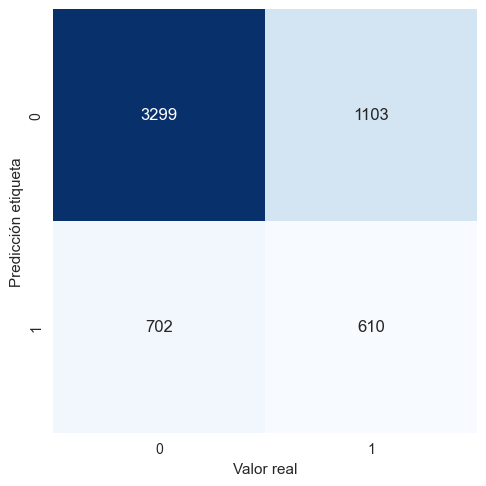

In [36]:
# Matriz de confusión
import seaborn as sns
from sklearn.metrics import confusion_matrix
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False, cmap = 'Blues')
plt.xlabel('Valor real')
plt.ylabel('Predicción etiqueta');

In [37]:
pred_proba= xgb_model.predict_proba(X_test_scaled_df)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

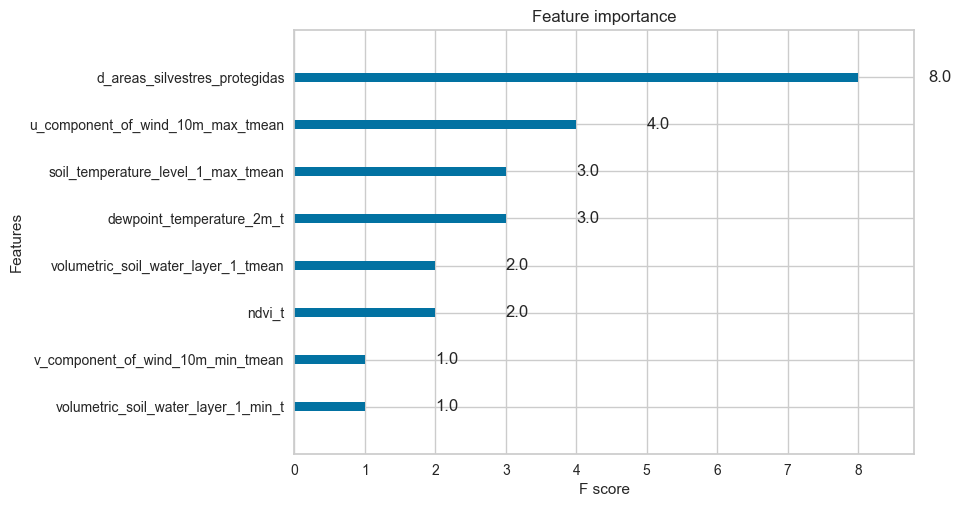

In [38]:
plot_importance(xgb_model, )


Calculando shap values

In [39]:
explainer = shap.Explainer(xgb_model, X_train_scaled_df)

shap_values = explainer.shap_values(X_test_scaled_df)

# primer valor set testeo
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0,:], X_test_scaled_df.iloc[0,:])


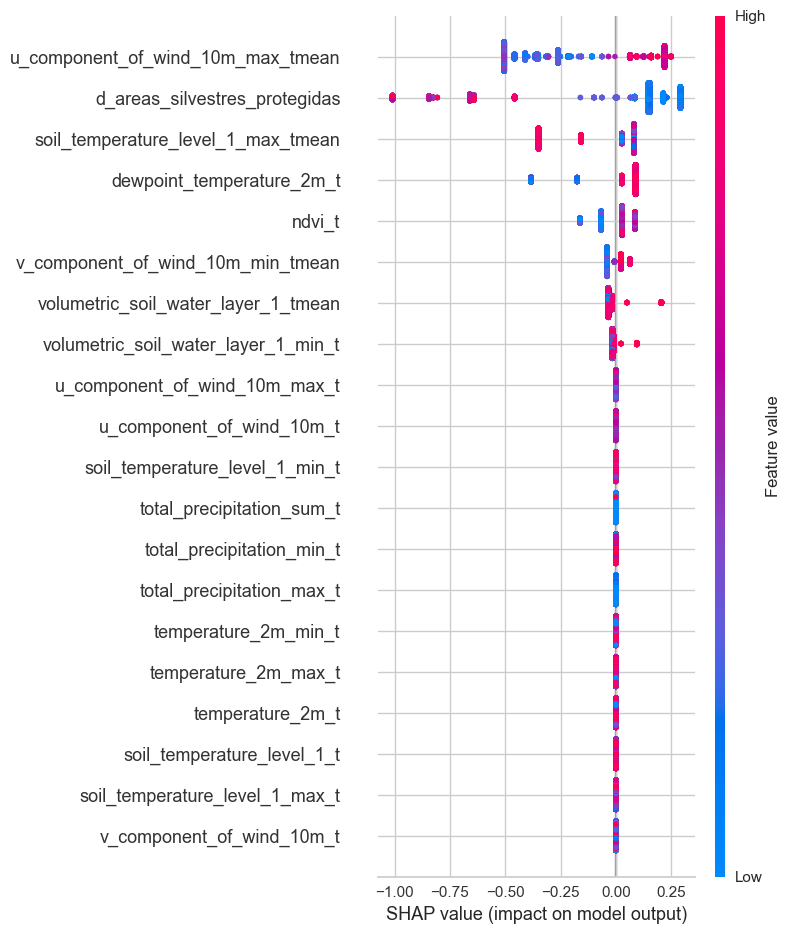

In [40]:
shap.summary_plot(shap_values, X_test_scaled_df)

#### VIZ

In [41]:
prob_pos = pred_proba[:, 1]

In [42]:
X_test.time.value_counts()

time
2022-12-14    2442
2022-12-19    1192
2022-11-19    1116
2023-05-08     964
Name: count, dtype: int64

In [43]:
X_test['prob'] = prob_pos
X_test['y_test'] = y_test

In [44]:
rev_dia = X_test[X_test['time']== '2022-12-19']

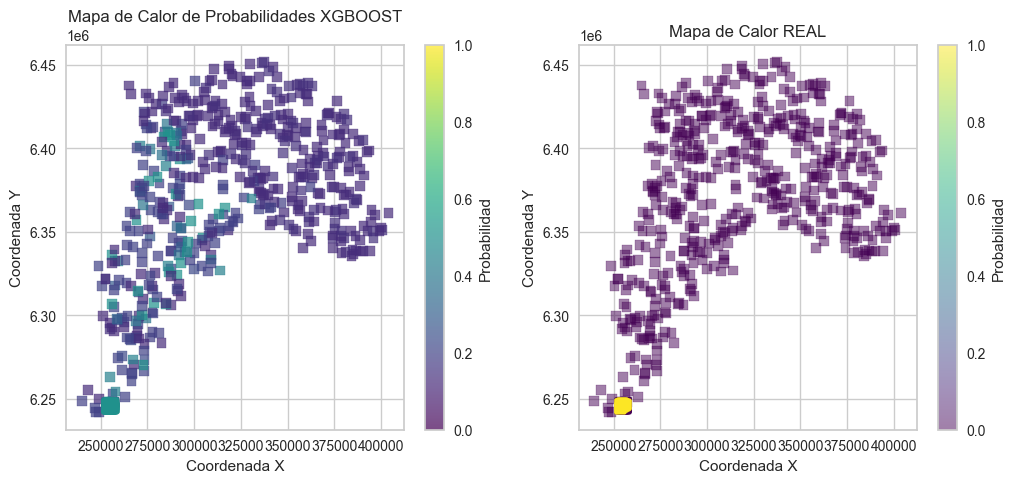

In [45]:
min_prob = min(prob_pos.min(), y_test.min())
max_prob = max(prob_pos.max(), y_test.max())

norm = Normalize(vmin=min_prob, vmax=max_prob)

plt.figure(figsize=(15, 5))


# Subgráfico 2: XGB
plt.subplot(1, 3, 2)
plt.scatter(rev_dia.x, rev_dia.y, c=rev_dia.prob, cmap='viridis', norm=norm, marker='s', s=50, alpha=0.7)
plt.colorbar(label='Probabilidad')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Mapa de Calor de Probabilidades XGBOOST')
plt.grid(True)

# Subgráfico 3: REAL
plt.subplot(1, 3, 3)
plt.scatter(rev_dia.x, rev_dia.y, c=rev_dia.y_test, cmap='viridis', norm=norm, marker='s', s=50, alpha=0.5)
plt.colorbar(label='Probabilidad')
plt.xlabel('Coordenada X')
plt.ylabel('Coordenada Y')
plt.title('Mapa de Calor REAL')
plt.grid(True)

# Ajustar el espacio entre los subgráficos para evitar superposiciones
plt.tight_layout()

# Mostrar los subgráficos
plt.show()



Guardando predicciones:

In [46]:
X_test['pred_XGB'] = prob_pos
X_test['es_incedio']= y_test
X_test.to_csv('predicciones_test.csv')

Guardando modelo:

In [47]:
import joblib
joblib.dump(xgb_model, 'xgb_model_v1.pkl')


X_train['es_incedio'] = y_train
aux = {'X_train': X_train , 'X_test': X_test, 'scaler': scaler}
joblib.dump(aux, 'train_test_scaler.pkl')

['train_test_scaler.pkl']